<a href="https://colab.research.google.com/github/scionrails/KIPRIS/blob/main/train_resnet50_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Google Drive 경로 설정
import os

# -------------------------------
# 인자 설정
# -------------------------------
SEED = 42

# -------------------------------
# 모델 저장 경로
# -------------------------------
MODEL_SAVE_DIR  = "/content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models"
os.makedirs(MODEL_SAVE_DIR , exist_ok=True)
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, f"best_resnet50_seed{SEED}.pth")
BEST_INFO_PATH = os.path.join(MODEL_SAVE_DIR, f"best_resnet50_seed{SEED}_info.json")

In [6]:
from google.colab import files
import os, shutil

# 업로드 요청
print("🔐 kaggle.json 파일을 업로드하세요 (API Key)")
uploaded = files.upload()

# 파일명 자동 추출
for filename in uploaded.keys():
    if filename.endswith(".json"):
        kaggle_json_path = filename
        break
else:
    raise ValueError("❌ JSON 형식의 파일이 없습니다.")

# ~/.kaggle 폴더 생성
kaggle_dir = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_dir, exist_ok=True)

# 복사 및 권한 설정
shutil.copy(kaggle_json_path, os.path.join(kaggle_dir, "kaggle.json"))

# 복사 후 원본 삭제
os.remove(kaggle_json_path)

os.chmod(os.path.join(kaggle_dir, "kaggle.json"), 0o600)

print("✅ kaggle.json 설정 완료 (내용은 출력하지 않음)")


🔐 kaggle.json 파일을 업로드하세요 (API Key)


Saving kaggle.json to kaggle.json
✅ kaggle.json 설정 완료 (내용은 출력하지 않음)


In [7]:
# 3. 데이터셋 다운로드 및 압축 해제
!kaggle datasets download -d safi842/highcarbon-micrographs --unzip -p ./metal_dataset

Dataset URL: https://www.kaggle.com/datasets/safi842/highcarbon-micrographs
License(s): copyright-authors
 95% 403M/426M [00:00<00:00, 442MB/s]
100% 426M/426M [00:00<00:00, 482MB/s]


In [8]:
import os
import shutil
import pandas as pd

# 경로 설정
excel_path = "metal_dataset/new_metadata.xlsx"
image_dir = "metal_dataset/For Training/Cropped"  # 실제 경로 반영
output_dir = "metal_dataset_sorted"

# 엑셀 읽기
df = pd.read_excel(excel_path)

# 폴더 정리 시작
for _, row in df.iterrows():
    filename = row['path']  # 예: 'micrograph973.png'
    real_filename = f"Cropped{filename}"  # 실제 존재하는 파일 이름
    label = str(row['primary_microconstituent']).strip().lower().replace(" ", "_").replace("+", "_plus_")

    src = os.path.join(image_dir, real_filename)
    dst_dir = os.path.join(output_dir, label)
    dst = os.path.join(dst_dir, real_filename)

    os.makedirs(dst_dir, exist_ok=True)

    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"[경고] 이미지 파일 없음: {src}")


In [9]:
# check_label_distribution.py

import pandas as pd

# 엑셀 경로
excel_path = "metal_dataset/new_metadata.xlsx"

# 라벨 정규화 함수 정의
def normalize_label(label):
    if pd.isna(label):
        return "unknown"
    return str(label).strip().lower().replace(" ", "_").replace("+", "_plus_")

# 엑셀 파일 읽기
df = pd.read_excel(excel_path)

# 라벨 정규화
df['normalized_label'] = df['primary_microconstituent'].apply(normalize_label)

# 고유 라벨 분포 집계
label_counts = df['normalized_label'].value_counts()

# 결과 출력
print(f"전체 이미지 수 (엑셀 기준): {len(df)}")
print("고유 라벨 분포:")
print(label_counts)

# 결과를 파일로 저장 (선택)
label_counts.to_csv("label_distribution_summary.csv")

전체 이미지 수 (엑셀 기준): 598
고유 라벨 분포:
normalized_label
spheroidite                       372
network                           101
spheroidite_plus_widmanstatten     77
pearlite_plus_spheroidite          28
pearlite                           15
pearlite_plus_widmanstatten         5
Name: count, dtype: int64


In [10]:
# 03_split_dataset.py

import os
import shutil
import random

# 설정
INPUT_DIR = "metal_dataset_sorted"
OUTPUT_DIR = "dataset_split"
SPLIT_RATIOS = (0.8, 0.1, 0.1)  # train : val : test

# 시드 고정
random.seed(SEED)

# 클래스 순회
for class_name in os.listdir(INPUT_DIR):
    class_path = os.path.join(INPUT_DIR, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
    total = len(images)
    random.shuffle(images)

    # 기본 분할 수 계산
    n_train = int(total * SPLIT_RATIOS[0])
    n_val   = int(total * SPLIT_RATIOS[1])
    n_test  = total - n_train - n_val

    # 최소 1장씩 보장
    if total >= 3:
        n_train = max(n_train, 1)
        n_val = max(n_val, 1)
        n_test = max(n_test, 1)

        while n_train + n_val + n_test > total:
            n_train -= 1  # 총합이 초과되면 하나 줄임
    elif total == 2:
        n_train, n_val, n_test = 1, 1, 0
    elif total == 1:
        n_train, n_val, n_test = 1, 0, 0
    else:
        print(f"[주의] {class_name} 클래스에 이미지 없음. 건너뜀.")
        continue

    split_sets = {
        'train': images[:n_train],
        'val': images[n_train:n_train + n_val],
        'test': images[n_train + n_val:n_train + n_val + n_test]
    }

    # 디렉토리 생성 및 이미지 복사
    for split_name, split_images in split_sets.items():
        split_dir = os.path.join(OUTPUT_DIR, split_name, class_name)
        os.makedirs(split_dir, exist_ok=True)

        for img_name in split_images:
            src = os.path.join(class_path, img_name)
            dst = os.path.join(split_dir, img_name)
            shutil.copy2(src, dst)

    print(f"{class_name:<40} → 총 {total}장 | train: {len(split_sets['train'])}, val: {len(split_sets['val'])}, test: {len(split_sets['test'])}")

pearlite_plus_spheroidite                → 총 28장 | train: 22, val: 2, test: 4
network                                  → 총 101장 | train: 80, val: 10, test: 11
pearlite_plus_widmanstatten              → 총 5장 | train: 3, val: 1, test: 1
spheroidite                              → 총 372장 | train: 297, val: 37, test: 38
spheroidite_plus_widmanstatten           → 총 77장 | train: 61, val: 7, test: 9
pearlite                                 → 총 15장 | train: 12, val: 1, test: 2


In [12]:
# train_resnet.py

import os
import json
import argparse
from collections import Counter

import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, models, transforms
from tqdm import tqdm


# -------------------------------
# 시드 고정
# -------------------------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -------------------------------
# 하이퍼파라미터
# -------------------------------
DATASET_DIR = "dataset_split"
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
NUM_WORKERS = 0
NUM_CLASSES = 6
NUM_EPOCHS = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------------
# Transform
# -------------------------------
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
val_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# -------------------------------
# Dataset
# -------------------------------
train_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, "train"), transform=train_transform)
val_dataset   = datasets.ImageFolder(os.path.join(DATASET_DIR, "val"), transform=val_transform)

# 클래스 저장
with open("class_to_idx.json", "w") as f:
    json.dump(train_dataset.class_to_idx, f, indent=2)

# -------------------------------
# Sampler
# -------------------------------
def get_sampler(dataset):
    targets = dataset.targets
    class_counts = Counter(targets)
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[t] for t in targets]
    return WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=get_sampler(train_dataset), num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# -------------------------------
# 모델 정의
# -------------------------------
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# -------------------------------
# 학습 루프
# -------------------------------
best_acc = 0.0
for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in tqdm(train_loader, desc=f"[Epoch {epoch+1}/{NUM_EPOCHS}]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss /= total

    # -------------------------------
    # 검증
    # -------------------------------
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # -------------------------------
    # 모델 저장
    # -------------------------------
    if val_acc > best_acc:
        best_acc = val_acc

        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,
            'train_acc': train_acc,
            'val_acc': val_acc,
            'seed': SEED,
        }, MODEL_SAVE_PATH)

        best_info = {
            'model_path': MODEL_SAVE_PATH,
            'train_acc': round(train_acc, 4),
            'val_acc': round(val_acc, 4),
            'epoch': epoch + 1,
            'seed': SEED
        }

        with open(BEST_INFO_PATH, 'w') as f:
            json.dump(best_info, f, indent=2)

        print(f"✅ 모델 저장됨: {MODEL_SAVE_PATH}")
        print(f"ℹ️  Best model info 저장됨: {BEST_INFO_PATH}")

print(f"\n🎯 학습 완료. 최고 검증 정확도: {best_acc:.4f}")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 170MB/s]
[Epoch 1/20]: 100%|██████████| 15/15 [00:13<00:00,  1.13it/s]


Epoch 1: Train Loss = 1.5627, Train Acc = 0.5768, Val Acc = 0.6034
✅ 모델 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42.pth
ℹ️  Best model info 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42_info.json


[Epoch 2/20]: 100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Epoch 2: Train Loss = 0.9596, Train Acc = 0.8589, Val Acc = 0.7069
✅ 모델 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42.pth
ℹ️  Best model info 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42_info.json


[Epoch 3/20]: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 3: Train Loss = 0.5559, Train Acc = 0.8821, Val Acc = 0.7586
✅ 모델 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42.pth
ℹ️  Best model info 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42_info.json


[Epoch 4/20]: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 4: Train Loss = 0.2303, Train Acc = 0.9432, Val Acc = 0.8276
✅ 모델 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42.pth
ℹ️  Best model info 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42_info.json


[Epoch 5/20]: 100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Epoch 5: Train Loss = 0.1705, Train Acc = 0.9432, Val Acc = 0.8793
✅ 모델 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42.pth
ℹ️  Best model info 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42_info.json


[Epoch 6/20]: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 6: Train Loss = 0.1354, Train Acc = 0.9558, Val Acc = 0.8966
✅ 모델 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42.pth
ℹ️  Best model info 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42_info.json


[Epoch 7/20]: 100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Epoch 7: Train Loss = 0.0839, Train Acc = 0.9895, Val Acc = 0.9310
✅ 모델 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42.pth
ℹ️  Best model info 저장됨: /content/drive/MyDrive/Research/microstructual images of steels and properities/metal_model/best_models/best_resnet50_seed42_info.json


[Epoch 8/20]: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 8: Train Loss = 0.0938, Train Acc = 0.9789, Val Acc = 0.8966


[Epoch 9/20]: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 9: Train Loss = 0.0798, Train Acc = 0.9768, Val Acc = 0.9310


[Epoch 10/20]: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 10: Train Loss = 0.0695, Train Acc = 0.9874, Val Acc = 0.9310


[Epoch 11/20]: 100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Epoch 11: Train Loss = 0.0520, Train Acc = 0.9853, Val Acc = 0.9138


[Epoch 12/20]: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 12: Train Loss = 0.0519, Train Acc = 0.9832, Val Acc = 0.9310


[Epoch 13/20]: 100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Epoch 13: Train Loss = 0.0851, Train Acc = 0.9747, Val Acc = 0.8966


[Epoch 14/20]: 100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Epoch 14: Train Loss = 0.0482, Train Acc = 0.9874, Val Acc = 0.9138


[Epoch 15/20]: 100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


Epoch 15: Train Loss = 0.0298, Train Acc = 0.9937, Val Acc = 0.9138


[Epoch 16/20]: 100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Epoch 16: Train Loss = 0.0297, Train Acc = 0.9958, Val Acc = 0.9138


[Epoch 17/20]: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 17: Train Loss = 0.0301, Train Acc = 0.9937, Val Acc = 0.9310


[Epoch 18/20]: 100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Epoch 18: Train Loss = 0.0144, Train Acc = 0.9979, Val Acc = 0.9138


[Epoch 19/20]: 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Epoch 19: Train Loss = 0.0312, Train Acc = 0.9895, Val Acc = 0.9310


[Epoch 20/20]: 100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Epoch 20: Train Loss = 0.0283, Train Acc = 0.9979, Val Acc = 0.8793

🎯 학습 완료. 최고 검증 정확도: 0.9310



🧪 테스트셋 성능 평가 중...

📊 Classification Report:
                                precision    recall  f1-score   support

                       network       1.00      1.00      1.00        11
                      pearlite       1.00      1.00      1.00         2
     pearlite_plus_spheroidite       0.75      0.75      0.75         4
   pearlite_plus_widmanstatten       1.00      1.00      1.00         1
                   spheroidite       0.90      0.92      0.91        38
spheroidite_plus_widmanstatten       0.75      0.67      0.71         9

                      accuracy                           0.89        65
                     macro avg       0.90      0.89      0.89        65
                  weighted avg       0.89      0.89      0.89        65



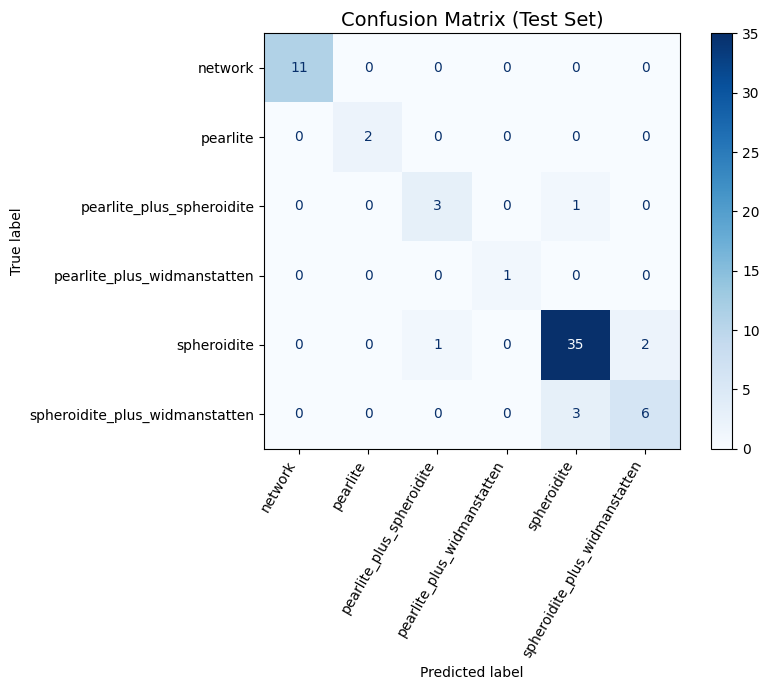

In [16]:
# -------------------------------
# 테스트셋 평가
# -------------------------------
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print("\n🧪 테스트셋 성능 평가 중...")

# Transform (val과 동일)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# TestSet 로드
test_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, "test"), transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 저장된 best 모델 로드
checkpoint = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 예측 수행
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.cpu().numpy())

# 클래스 이름 불러오기
with open("class_to_idx.json", "r") as f:
    class_to_idx = json.load(f)
idx_to_class = {v: k for k, v in class_to_idx.items()}
target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# 결과 출력
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix 시각화 및 저장
cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(9, 7))  # 그림 크기 충분히 확보
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(ax=ax, cmap="Blues", colorbar=True)

# x축 레이블 회전과 정렬
plt.xticks(rotation=60, ha='right')
plt.title("Confusion Matrix (Test Set)", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=300)
plt.show()